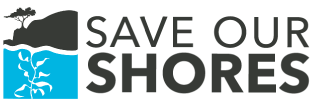

# Visualizations of Save Our Shores Cleanup Data 2013-2022

[Save Our Shores](https://saveourshores.org) (SOS) is a non-profit dedicated to ocean conservation in the Monterey Bay through education, advocacy, and beach cleanups. SOS organize many cleanup events every year, and they also coordinate over 60 cleanup sites around the Monterey Bay Marine National Sanctuary for the Annual Coastal Cleanup Day in September every year. For each event, data such as location, number of volunteers, duration, weight of trash and recycling, and types of items cleaned up are registered, and data has been collected since 2013.

This creates a rich data set that can e.g. be used to help drive policy changes around single use plastic. NOAA used the SOS data, along with other data sets, in their recent report ["Marine debris on the shoreline of Monterey Bay National Marine Sanctuary: An assessment of behaviors contributing to marine debris, categories & composition, spatial distribution, and predictor variables"](https://marinedebris.noaa.gov/other-reports/marine-debris-shoreline-monterey-bay-national-marine-sanctuary-assessment-behaviors), where they analyzed what types of trash are most prevalent, what activities they stem from, as well as exploring predictors of marine debris and suggesting recommendations.

A current focus for SOS is reducing cigarette butt waste, which is prevalent and negatively impacts our ecosystems. [Cigarette butts are made of single use plastic and don't help protect smokers from negative effects, which raises the question why they are tolerated](https://www.theguardian.com/environment/2022/aug/18/cigarette-butts-how-the-no-1-most-littered-objects-are-choking-our-coasts).

The SOS data has been stored in 1-2 xslx files for each year, with a wide variety of item names, types and site names. Code for data cleanup and plots can be found [on GitHub](https://github.com/jennyfolkesson/cleanupShores).

When possible, item categories have a similar stucture to those in NOAA's Monterey Bay National Marine Sanctuary Marine Debris report. There are some open questions, such as if items should be grouped by material or type, and what to do when the material is unknown. The code for categorizing items can be seen in the GitHub link above.

This document will be updated with more graphs as the data is further explored.

In [1]:
import circlify
import glob
import numpy as np
import os
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from pprint import pprint
import tabulate

import cleanup as cleanup 
import graphs as graphs

import plotly.io as pio
from plotly.offline import init_notebook_mode

pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=True)

Read the file where data from all years are gathered, or create it if it is't in the directory already.

In [2]:
data_dir = '/Users/jenny.folkesson/Data/SOS Cleanup Data 2013-2022'
sos_data, col_config = cleanup.read_data(data_dir)

Below you can see the structure of the combined 2013-2022 data set. All the columns and the first five rows are on display.

In [3]:
sos_data.head()

,Date,Cleanup Site,Data Collection,Duration (Hrs),Adult Volunteers,Youth Volunteers,Trash (lbs),Recycling (lbs),County/City,Type Of Cleanup,...,Other,Nails,Cleaned Size (Sq Miles),Aluminum Foil,Bikes,Car Parts,Footwear,Beverage Bottles,Total Items,Total Volunteers
0,2013-01-12,Del Monte Beach,NaN,2.0,35.0,NaN,119.0,28.0,Monterey/Monterey,NaN,...,23.0,6.0,0.0,16.0,2.0,0.0,1.0,NaN,3799.0,35.0
1,2013-01-12,Manresa State Beach,NaN,2.0,24.0,NaN,20.0,11.0,Watsonville/Santa Cruz County,NaN,...,11.0,33.0,2.0,109.0,0.0,0.0,59.0,NaN,6169.0,24.0
2,2013-01-18,New Brighton State Beach,NaN,2.0,32.0,NaN,5.0,0.0,Santa Cruz/Santa Cruz,NaN,...,2.0,0.0,1.0,6.0,0.0,2.0,0.0,NaN,60.0,32.0
3,2013-01-18,Seabright State Beach,NaN,2.0,40.0,NaN,40.0,20.0,Santa Cruz/Santa Cruz,NaN,...,0.0,0.0,0.0,1.0,3.0,0.0,3.0,NaN,293.0,40.0
4,2013-01-19,Seacliff State Beach,NaN,3.0,51.0,NaN,33.0,5.0,Aptos/Santa Cruz,NaN,...,9.0,2.0,2.0,35.0,0.0,0.0,4.0,NaN,2289.0,51.0


There's also a saved config file that describe the column names of the sos_data in further detail. For each column name, the following characteristics are listed:
* potential sources from individual years
* data type (datetime, str, int, float)
* required (boolean)
* material (plastic, wood, glass, metal, mixed). NA for non items
* activity (Various, Eating/Drinking, Dumping/Disaster, 'Smoking', 'Hygiene')

In [4]:
col_config.head()

,name,sources,type,required,material,activity
0,Date,"['Date', 'Date Of Cleanup Event/Fecha', 'Clean...",datetime,True,NaN,NaN
1,Cleanup Site,"['Cleanup Site', 'Cleanup Site/Sitio De Limpie...",str,True,NaN,NaN
2,Cleaned Size (Sq Miles),"['Cleaned Size (Sq Miles)', 'Estimated Size Of...",int,False,NaN,NaN
3,Data Collection,"['Data Collection', 'Data Collection Method']",str,False,NaN,NaN
4,Duration (Hrs),"['Duration (Hrs)', 'Total Cleanup Duration (Hr...",int,True,NaN,NaN


## Number of Items Collected in 2023 Color Coded by Material

This circle packing graph shows the total amount of items of the given categories that have been cleaned up by Save Our Shores from in 2023. The circle sizes correspond to the number of items. When circles are too small to display the text within them, the text has been removed, and you can instead hover over the circle to see the item category and number.
The circles are color coded based on their material, with the categories Mixed, Wood, Glass, Metal and Plastic.

In [5]:
# Instantiate graph making object
graph_maker = graphs.GraphMaker(data_dir, sos_data, col_config)

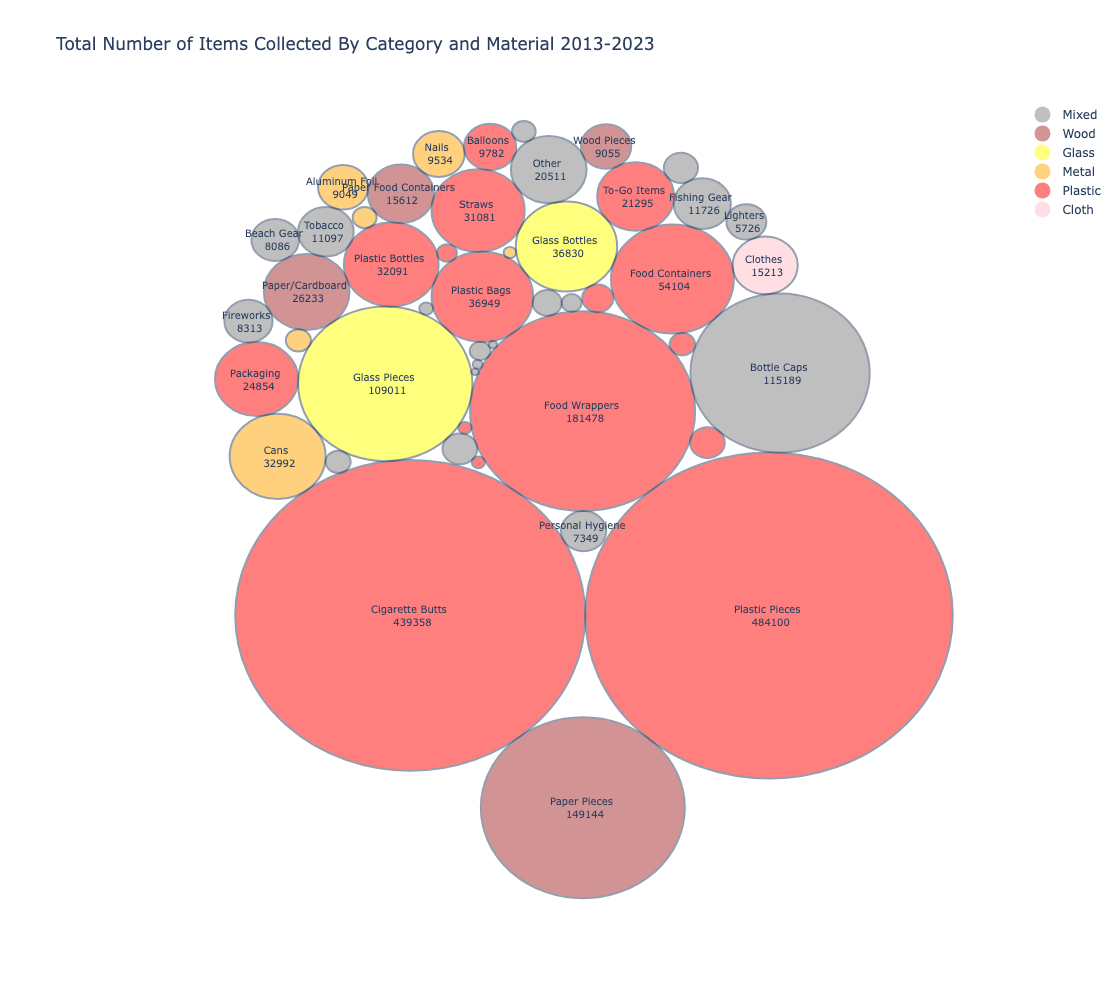

In [6]:
# Get data from 2013-2023 and make circle packing graph
fig = graph_maker.circle_packing_graph(plot_colors=None)
fig.show()

The above graph is a circle packing graph which shows the total number of items cleaned up by Save Our Shores 2013-2023, binned into the most common categories and color coded by material. The size of the circle is proportional to the number of items cleaned up. In circles too small to fit the item name and quanitity inside, you can hover over the center of the circle to find that information.

As you can see, plastic (in red) is by far the most common material of the marine debris cleaned up by SOS. Mixed material items (gray) like food containers, bottle caps and personal hygiene most likely contain a fair amount of plastic as well.

# Longitudinal Evaluation of Cleanup Items

Here we'll look at the number of items cleaned up by year from 2013-2023. First, let's just look at bar plots of items collected over the years and number of volunteers over the years.
In order to do that, we'll need to group the data by year. We'll also add a column for total number of volunteers, which was defined at number of adults * 0.5 * number of youths.

## Total Number of Items by Trash Category

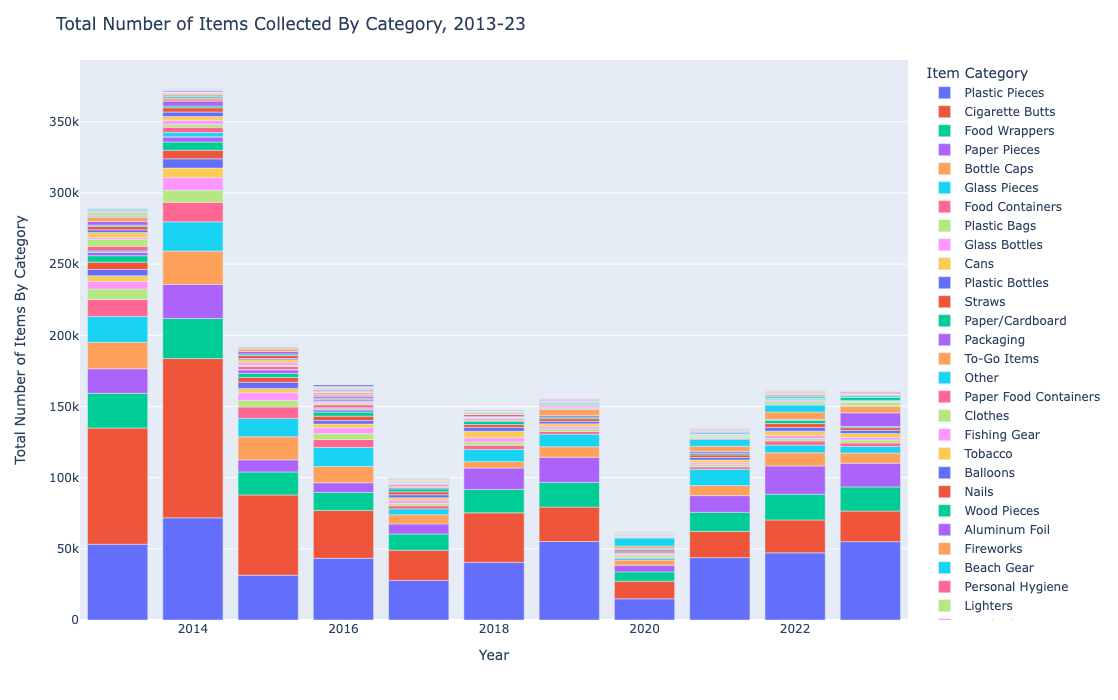

In [7]:
# Bar plot of all trash items over the years
fig = graph_maker.annual_total_bar()
fig.show()

The bar graph above shows the number of items cleaned up in the years 2013-2023 by category. You can click on the Item Category squares to the right to exclude/include categories in the graph.


## Top 5 Trash Categories
Below is the same bar plot as above but only the top 5 trash categories.

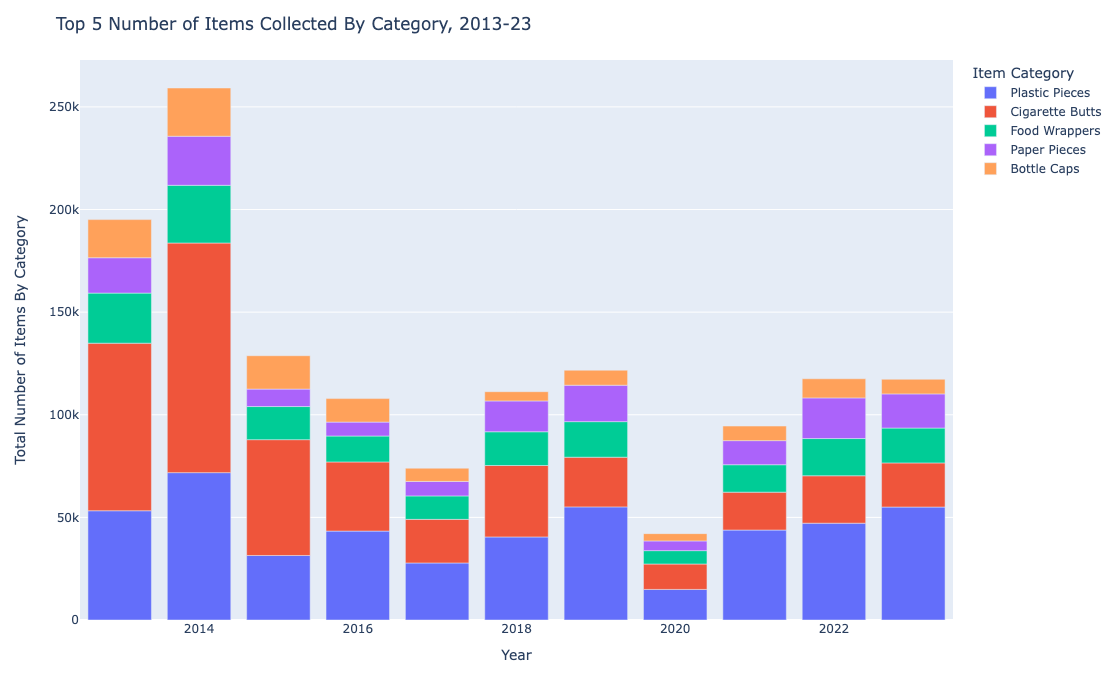

In [8]:
# Top 5 items over the years
fig = graph_maker.annual_total_bar(item_nbr=5)
fig.show()

## Total Number of Volunteers Each Year
Plot the total number of volunteers over the years. Total volunteers are defined as Adult Volunteers + 0.5 * Youth Volunteers, just like in the NOAA marine debris report.

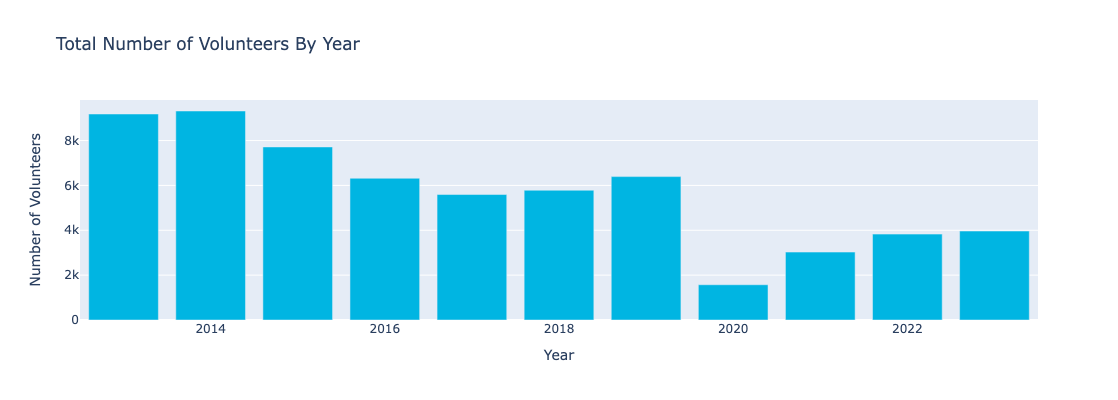

In [9]:
fig = graph_maker.annual_volunteers()
fig.show()

The bar plot with all trash categories above looks pretty busy, and it's hard to compare sizes of different colors when they're stacked on top of each other. 

## Correlation Between Number of Volunteers and Number of Trash Items Collected
It looks like total number of trash items and number of volunteers might be correlated, let's plot the number of items as a function of the number of volunteers. It makes sense that the more people are doing cleanup, the more things get cleaned up. We could multiply the number of hours of cleanup with the number of volunteers, but there seems to be some outliers in the Duration (hrs) data, so we'll skip that for now.
Plotted below are the number of items vs number of volunteers, each summarized over a one year period.

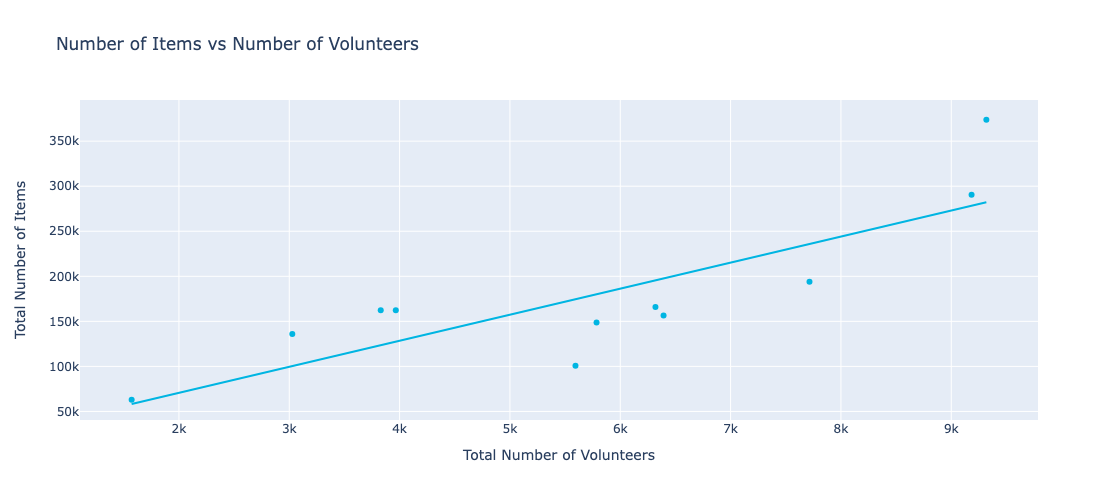

In [10]:
fig.data = []
fig = px.scatter(graph_maker.annual_data, 
                 x='Total Volunteers', 
                 y='Total Items', 
                 trendline="ols",
                 title="Number of Items vs Number of Volunteers",
                )
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    yaxis_title='Total Number of Items',
    xaxis_title='Total Number of Volunteers',
)
fig.update_traces(marker_color=graphs.SOS_BLUE)
fig.show()

In [11]:
# Get correlation stats
results = px.get_trendline_results(fig)

stats = [["", ""],
         ["R Squared", ""],
         ["p-value", ""],
         ["f(x)", ""]]

for idx in range(1):
    stats[1][idx + 1] = "{:.5f}".format(results.px_fit_results[idx].rsquared)
    stats[2][idx + 1] = "{}".format(results.px_fit_results[idx].pvalues[1])
    params = results.px_fit_results[idx].params
    stats[3][idx + 1] = "{:.1f}x + {:.1f}".format(params[1], params[0])

table = tabulate.tabulate(stats, tablefmt='html')
table

,
R Squared,0.68590
p-value,0.0016394442467381543
f(x),28.9x + 12849.1


There's a significant correlation between number of volunteers and number of items collected for each year, which suggests that the number of items collected in a year might depend on the number of volunteers doing beach cleanups that year. 
The fewer debris items collected in 2020 may have been a result of fewer people being out during the pandemic, and not necessarily due to less littering. 

## Number of Items Per Volunteer Grouped by Trash Category
Now that we know that there's a correlation between number of items and number of volunteers, let's plot items/volunteer over time.

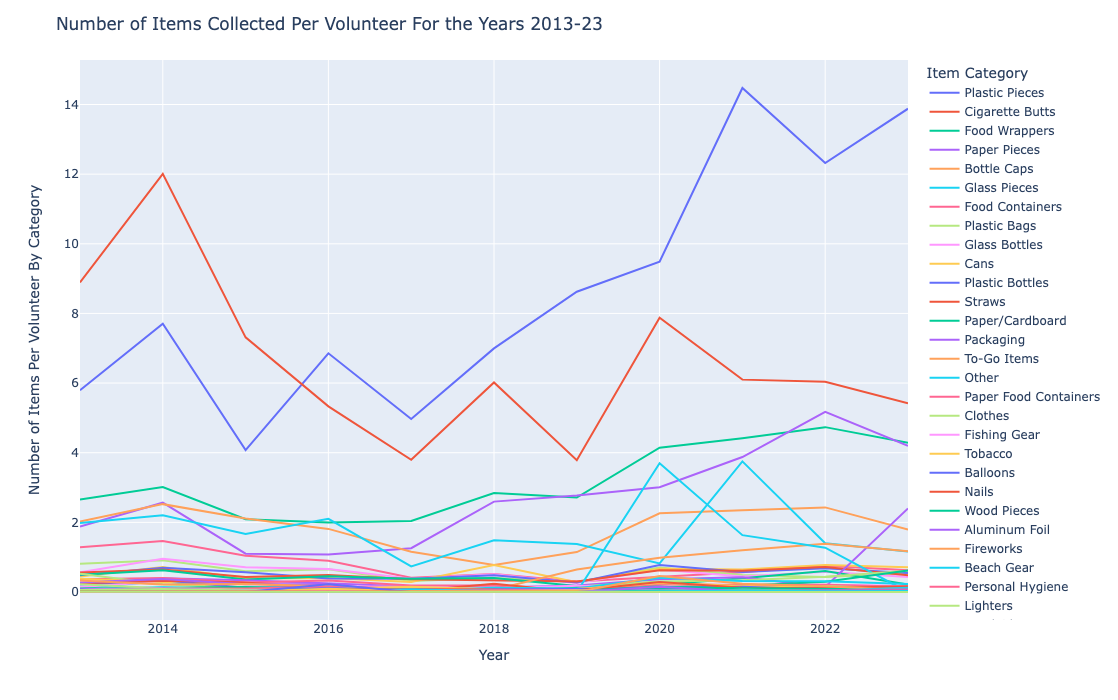

In [12]:
# Number of item per volunteer line graph 2013-23
fig = graph_maker.item_per_volunteer()
fig.show()

After division with number of volunteers, it seems there might be a slight decreasing trend for cigarette butts from 2020 onwards. Unfortunately there seems to be an increasing number of plastic pieces on our shores.

## Number of Items Per Volunteer Grouped by Trash Material
We'll group our data by trash material and look what's the most common material that's littering our coastline. This graph is similar to Figure 14 in NOAA's marine debris report, but instead of showing percentages of total number of trash items, we're plotting number of items from a given material per volunteer. Somewhat different categories are used as well: wood and paper are labeled wood.

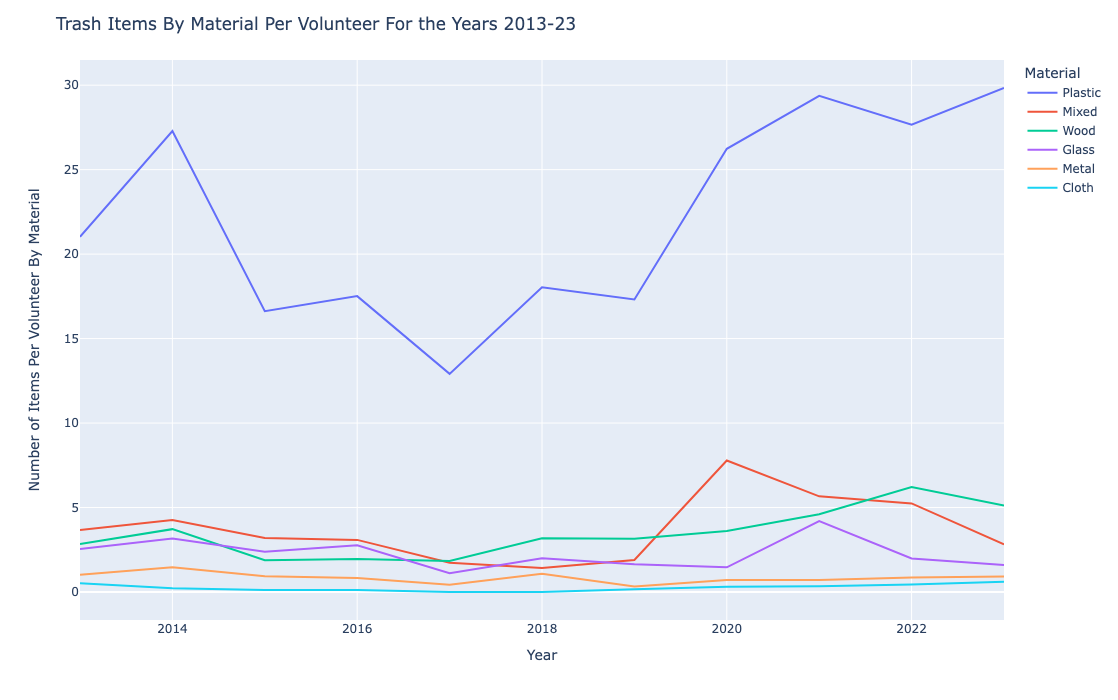

In [13]:
fig = graph_maker.material_per_volunteer()
fig.show()

It seems that plastic is by far the most common debris material on our shorelines, and it may be increasing.

# Number of Trash Items and Number of Vounteers by Cleanup Site

In the last section we looked at total number of items cleaned up over the years by Save Our Shores. Now we'll look at number of volunteers and number of items cleaned up by site.

There may be some overlap of site names as there were multiple names and spellings for what appeared to be similar sites. Some sites were located by lon, lat coordinates instead of site names, and those are not yet included here.
The code where site names are consolidated is here: https://github.com/jennyfolkesson/cleanupShores/blob/main/site_categories.yml

Plot number of volunteers by cleanup site for the top 25 results over 2013-2023.

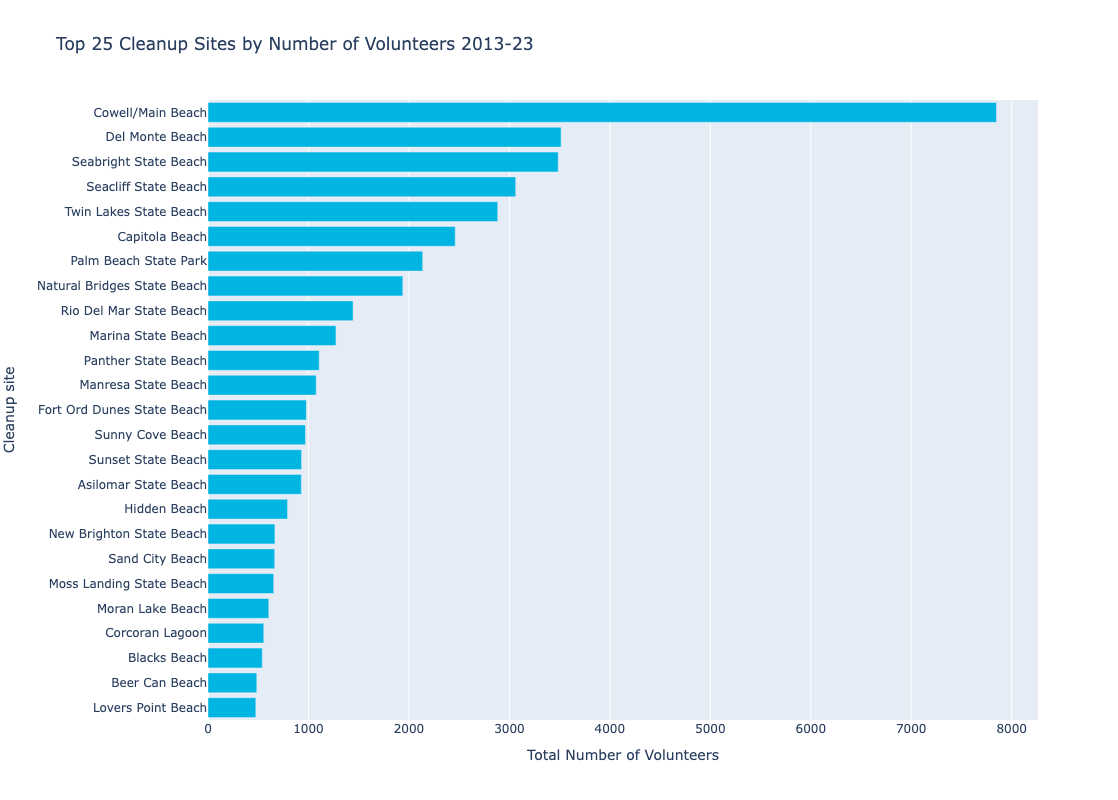

In [14]:
fig = graph_maker.volunteers_by_site()
fig.show()

This figure shows the total number of volunteers that have been involved in a cleanup event 2013-2022 per cleanup site. Youth volunteers, when reported, are counted as half an adult volunteer in line with the NOAA Marine Debris Report. Only the top 25 

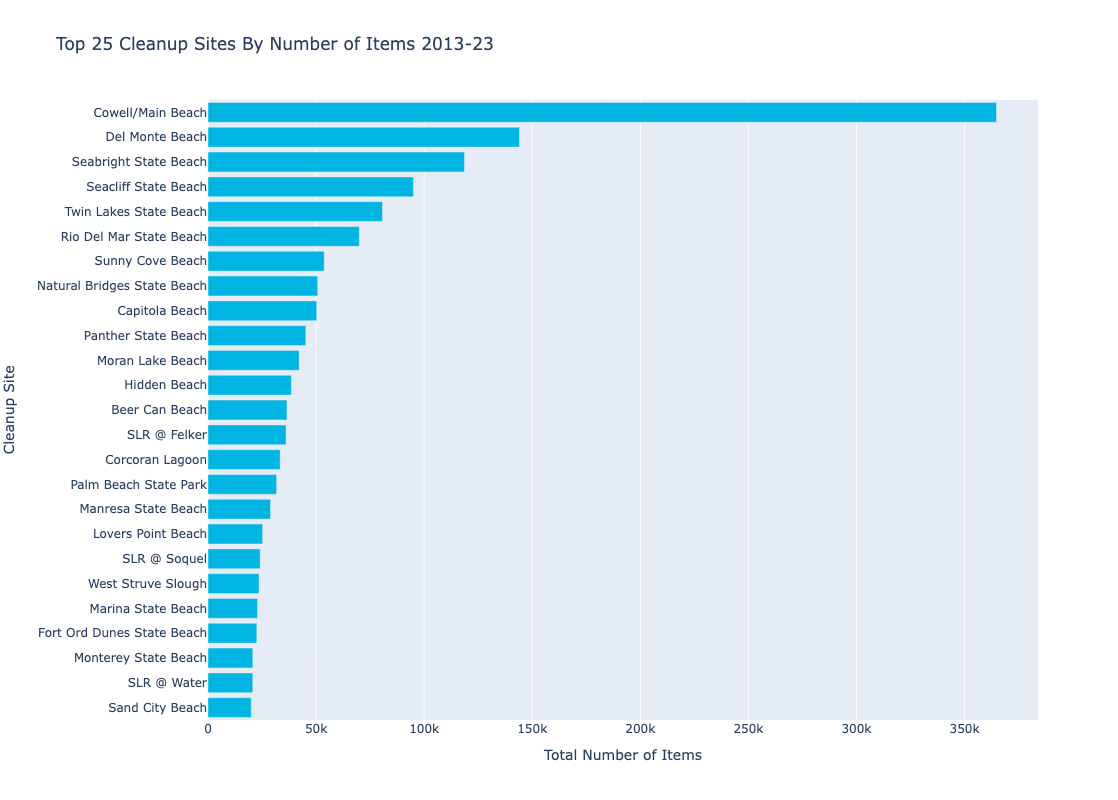

In [15]:
fig = graph_maker.items_by_site()
fig.show()

Total number of items cleaned up from 2013-2023 by cleanup site. Only top 25 results are displayed.

## Number of Cigarette Butts by Location 2013-2023

Plot the number of cigarette butts cleaned up for each site which we have geographic coordinates for. Each circle represents a cleanup site and the size of the circle corresponds to the number of cigarette butts cleaned up.

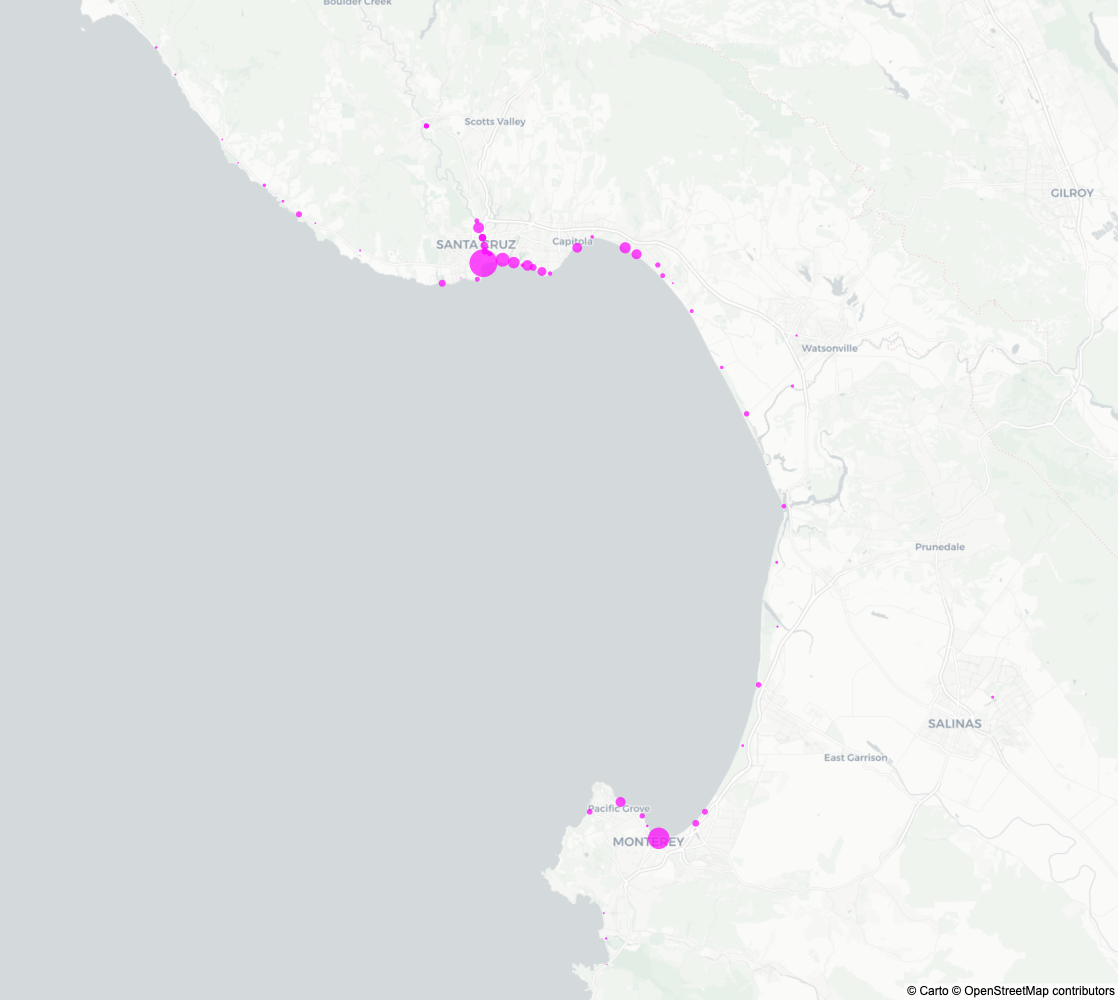

In [16]:
fig = graph_maker.cigarette_map()
fig.show()

The map above shows the sites where cigarette butts were collected in the years 2013-2023. The circles (in fuchsia) are centered on the cleanup site, and the size of the circles correspond to the number of cigarette butts cleaned up from that site. You can hover over the circle to get more information, and you can zoom in and out on the map by sliding down and up with two fingers on your trackpad. SLR stands for San Lorenzo River.

This plot is limited to sites with known coordinates, and coordinates successfully located with geopy. Cleanup sites that had coordinates provided for them are listed below.
(Note: I merged Corcoran Lagoon at 20th and 26th Ave to Corcoran Lagoon, and I merged two Del Monte Beach locations into one).

In [17]:
coords = pd.read_csv(os.path.join(data_dir, 'cleanup_site_coordinates.csv'))
print('\n'.join(list(coords['Cleanup Site'])))

Ano Nuevo State Beach
Asilomar State Beach
Beer Can Beach
Blacks Beach
Bonny Doon State Beach
Capitola Beach
Carmel Beach
Carmel Meadows/Ribera Beach
Carmel River State Beach
Corcoran Lagoon
Cowell/Main Beach
Davenport Landing Beach
Davenport Main Beach
Del Monte Beach
Fort Ord Dunes State Beach
Four-Mile State Beach
Greyhound Rock Beach
Hidden Beach
Laguna Creek Beach
Lighthouse Field State Beach
Lovers Point Beach
Manresa State Beach
Marina State Beach
Mcabee State Beach
Mitchell's Cove Beach
Monastery Beach
Monterey State Beach
Moran Lake Beach
Moss Landing State Beach
Natural Bridges State Beach
New Brighton State Beach
Pajaro River
Palm Beach State Park
Panther State Beach
Pleasure Point Beaches
Point Lobos State Natural Reserve
Rio Del Mar State Beach
SLR @ Felker
SLR @ Felton
SLR @ Felton
SLR @ Laurel
SLR @ Riverside
SLR @ Soquel
SLR @ The Tannery Arts Center
SLR @ Water
SLR @ Water
Salinas River National Wildlife Refuge
Salinas River State Beach
San Carlos Beach
Sand City Beach

## Debris Caused by Smoking, 2013-2023

Let's look at the categories specifically related to smoking and see how they've changed over time. Since there is a correlation between number of items collected and number of volunteers, we'll look at number of items per volunteer for each year. The smoking related items in the data set are: **Cigarette Butts**, **Cigar Tips**, **E-Waste**, and **Tobacco**. The Tobacco category includes items such as packaging and wrappers. Since some data categories for some year were e.g. 'Other Tobacco (Packaging, Lighter, Etc.)' or 'Smoking, Tobacco, Vape Items (Not Butts)', this general Tobacco category may include some lighters and e-waste items.

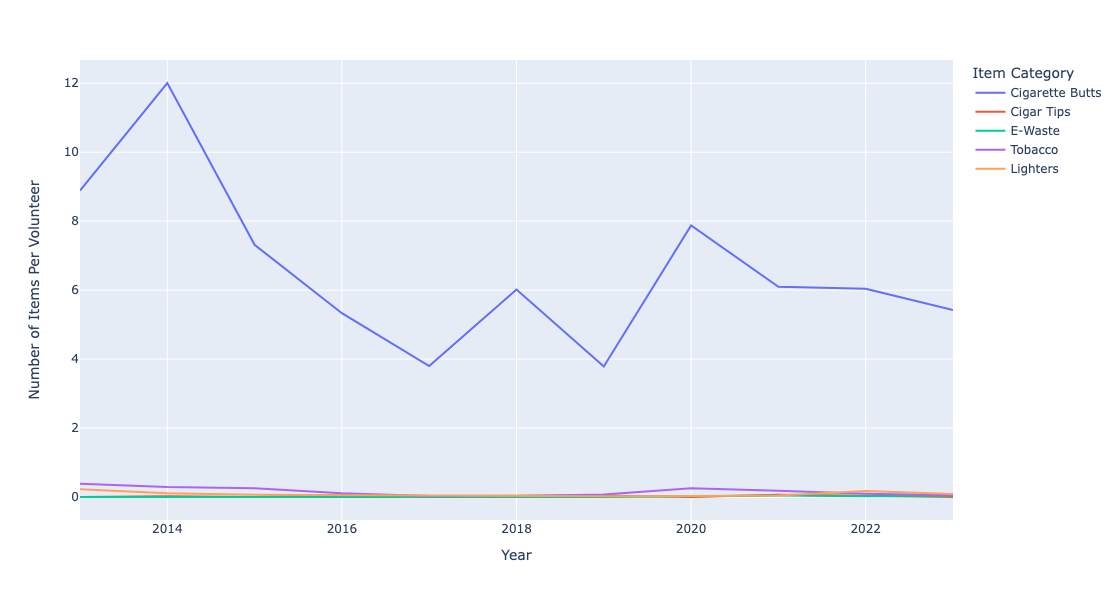

In [18]:
fig = graph_maker.smoking_line_graph()
fig.show()

Cigarette butts is by far the worst polluter among smoking categories and the second worst overall after plastic pieces.

## Debris Organized by Activity 2013-2023

In [NOAA's marine debris report](https://marinedebris.noaa.gov/other-reports/marine-debris-shoreline-monterey-bay-national-marine-sanctuary-assessment-behaviors-contributing-marine-debris-categories-composition-spatial-distribution-and-predictor-variables), in Section 3, trash is organized into the following activities:

* **Eating & Drinking:** Trash categories associated with eating and drinking include utensils and plates, take-out food containers, bottles, straws, and wrappers.
* **Smoking:** Trash left behind from smoking cigarettes, cigars, and vaping included butts, packaging, containers, and other smoking items.
* **Personal Hygiene:** Items include any personal protective or sanitary products such as masks, gloves, condoms, tampons, diapers and syringes.
* **Recreation:** Items associated with recreation on the beach or elsewhere (other than fishing) include balloons, toys, clothing, and dog waste bags.
* **Dumping and Disaster:** Industrial and household waste dumping includes trash that may originate from unintentional or illegal dumping. This category also includes items resulting from storm damage, coastal erosion, or degrading harbors. Items include appliances, construction
material, and tires.
* **Various:** Trash that could have originated from any one of the other six activities but could not be identified with a specific activity. Examples include packaging, caps and bottles that may not have contained beverages, and fragmented pieces of plastic, glass, or metal.

Here, Figure 10 in Section 3 of NOAA's report is recreated with SOS data only. The pie chart in the report is replaced with a bar chart for (in my opinion) more easily interpretable results. Activity names are sligthy modified to **Eating/Drinking**, **Smoking**, **Hygiene**, **Recreation**, **Dumping/Disaster** and **Various**.

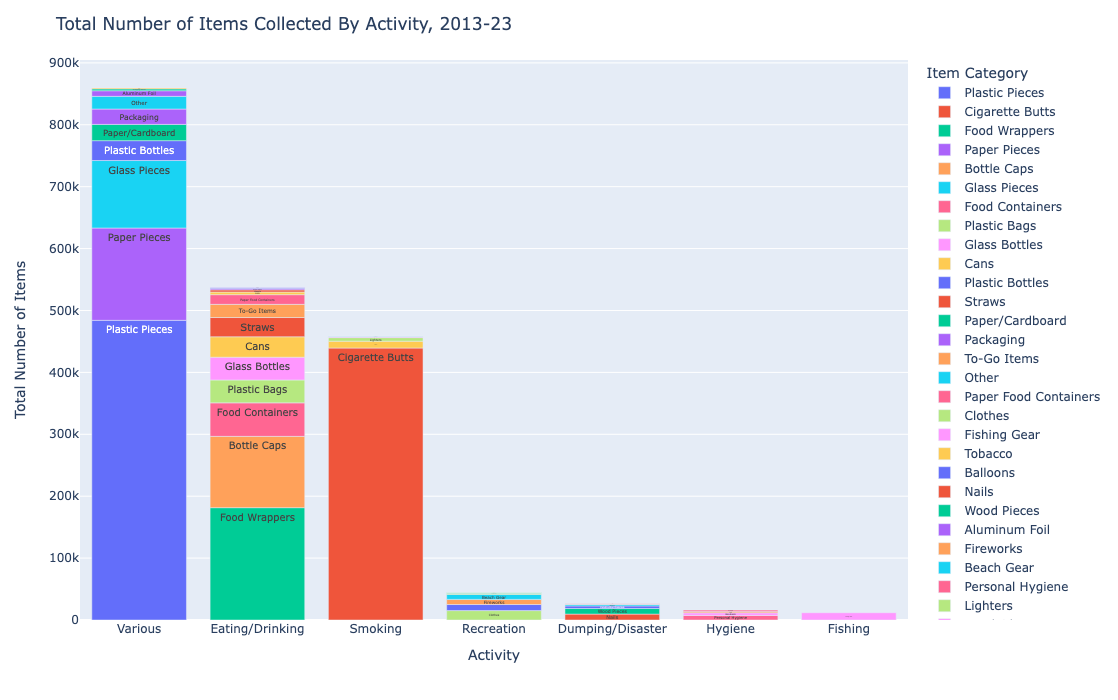

In [19]:
fig = graph_maker.activity_graph()
fig.show()

Eating and drinking contributed to the most marine debris of all the recognizable activites (not including Various). After that comes smoking, and the vast majority of Smoking items were cigarette butts. Recreation, Dumping/Disaster, Hygiene and Fishing resulted in much fewer trash items than the other two recognizable activities.
The single largest trash item from any recognizable activity was cigarett butts, despite the fact that only about 10% of Californians smoke but we all eat and drink.